In [30]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
import pickle

import sys
from pathlib import Path

PROJECT_ROOT = str(Path.cwd().parent.resolve())
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import Class_site as site
import free_fermion_representation as f
import variables_phasediagram_simulation as vps
import honeycomb_plot as honey

import importlib

importlib.reload(site)
importlib.reload(f)
importlib.reload(vps)
importlib.reload(honey)

<module 'honeycomb_plot' from '/Users/giovanniconcheri/Desktop/TESI/MasterThesis/honeycomb_plot.py'>

In [31]:
model = site.SitesOBC(Npx = 21, Npy = 21, edge = True)
fgs = f.FermionicGaussianRepresentation(model)

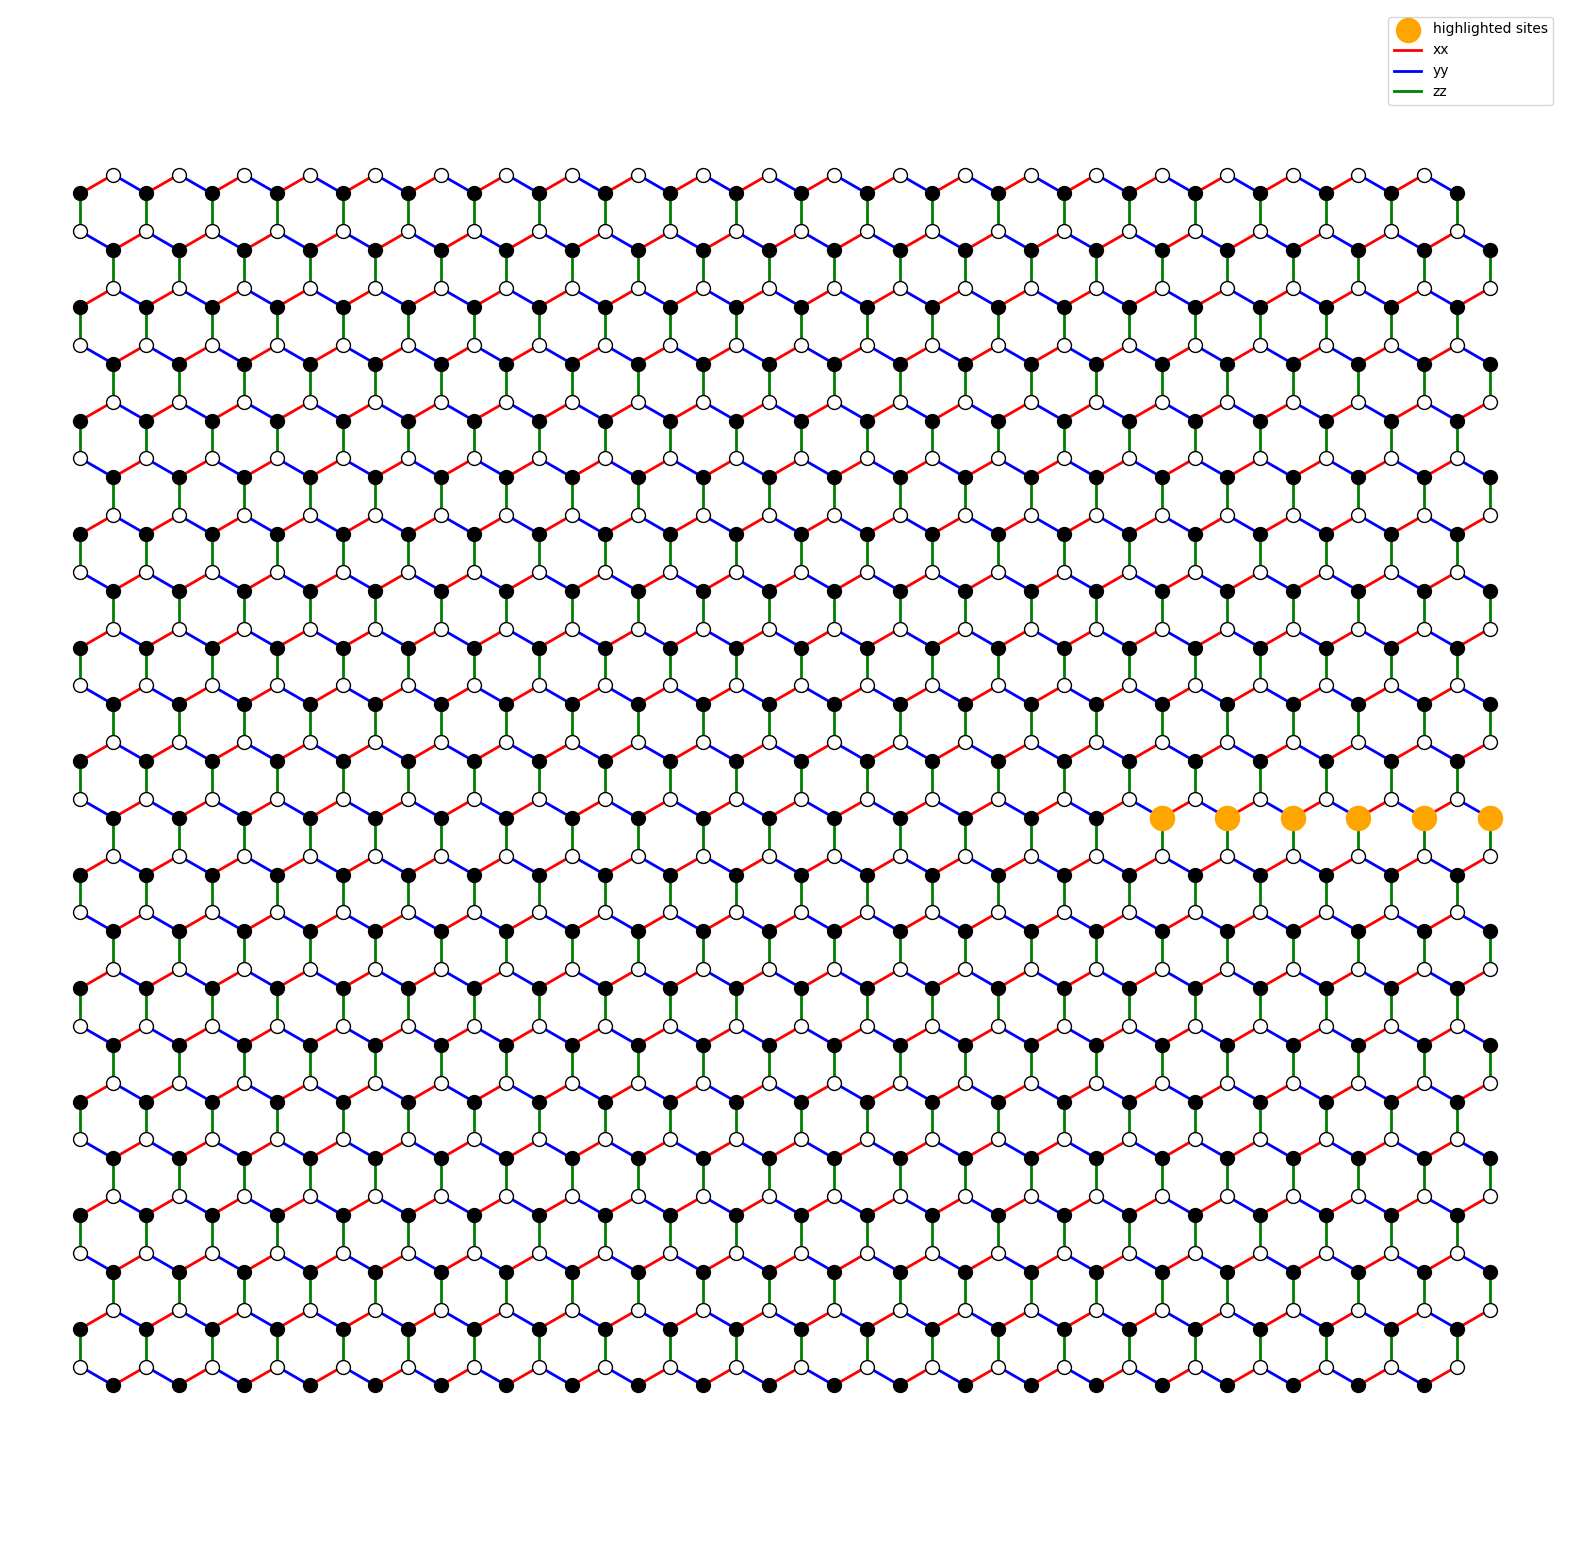

In [32]:
current_sites = model.get_current_sites()
honey.plot_honeycomb(model, sites=current_sites)

In [33]:
def current_delta_T(model, fgs, T, delta, N_cycles, edgepar = None):

    fgs.reset_cov_0_matrix()
    # fgs.reset_cov_e_matrix()

    _, _, _, R0 = fgs.floquet_operator_ham(T)
    # _, _, _, Re = fgs.floquet_operator_ham(T, anyon=True)
    
    if delta != 0:
        V0 = f.generate_disorder_term(model, fgs.Cov, delta, edgepar = edgepar)
        # Ve = f.generate_disorder_term(model, fgs.Cov, delta, type="Anyon", edgepar = edgepar)
        R_V0 = f.floquet_operator(V0, T, alpha = np.pi/4.)
        # R_Ve = f.floquet_operator(Ve, T, alpha = np.pi/4.)
        R_V0_R0 = R_V0 @ R0
        # R_Ve_Re = R_Ve @ Re
    else:
        R_V0_R0 = R0
        # R_Ve_Re = Re

    density = []
    current = []

    for _ in range(N_cycles):
        density.append(fgs.current_density_tilde(fgs.Cov_0))
        fgs.update_cov_0_matrix(R_V0_R0)    
        # fgs.update_cov_e_matrix(R_Ve_Re)
    density.append(fgs.current_density_tilde(fgs.Cov_0))

    for i in range(N_cycles):
        transport = 0
        for j in range(len(density[i])):
            transport += density[i+1][j] - density[i][j]
        current.append(transport)

    average_current = np.mean(current)

    return density, current, average_current

In [34]:
def current(delta_list, T_list, model, fgs, N_cycles):
    results = np.empty((len(delta_list), len(T_list)), dtype=object)
    current_per_T = {}

    for j, T in enumerate(tqdm(T_list, desc='T loop')):
        current_per_T[T] = []
        for i, delta in enumerate(tqdm(delta_list, desc='Delta loop', leave=False)):

            density, current, avg_current = current_delta_T(model, fgs, T, delta, N_cycles)
            results[i, j] = {
                'density': density,
                'current': current,
                'avg_current': avg_current
            }
            current_per_T[T].append(avg_current)

    return results, current_per_T


In [39]:
delta_list = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
T_list = vps.T_list_0

In [40]:
results, current_per_T = current(delta_list, [1], model, fgs, N_cycles = 10)

T loop:   0%|          | 0/1 [00:00<?, ?it/s]

Delta loop:   0%|          | 0/11 [00:00<?, ?it/s]

In [41]:
def plot_current_per_T(delta_list, current_per_T):
    plt.figure(figsize=(8,6))
    for T, currents in current_per_T.items():
        plt.plot(delta_list, currents, marker='o', label=f'T={T:.2f}')
    plt.xlabel('Disorder Strength Δ')
    plt.ylabel('Average Current')
    plt.title('Average Current vs Disorder Strength for Different T')
    plt.legend()
    plt.grid()
    plt.show()

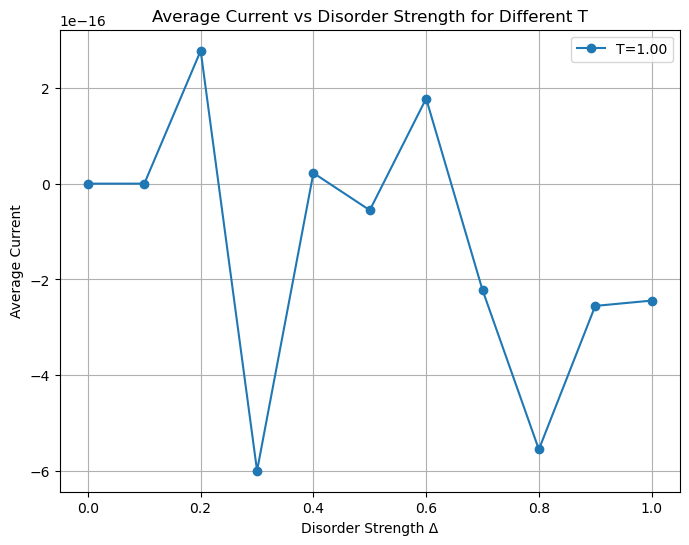

In [42]:
plot_current_per_T(delta_list, current_per_T)